# load the dataset

using the titanic dataset, downloaded from [data.world](https://data.world/nrippner/titanic-disaster-dataset)

description:

- survival - Survival (0 = No; 1 = Yes)
- class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- boat - Lifeboat (if survived)
- body - Body number (if did not survive and body was recovered)

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras import models, Model, layers
from tensorflow.keras.callbacks import EarlyStopping

from pprint import pprint
from enhance_data import enhance_data
#from impyute.imputation.cs import mice


pd.set_option('display.width', 5000, 'display.max_columns', 100)

In [2]:
with open('./data/titanic.csv', mode='r') as file:
    df = pd.read_csv(file)

> first look at the data

In [3]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [5]:
df.shape

(1310, 14)

1310 observations, 14 attributes

## data conversion

In [6]:
df.dtypes

pclass       float64
survived     float64
name          object
sex           object
age          float64
sibsp        float64
parch        float64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [7]:
#for i in ['pclass', 'sex', 'embarked', 'boat']:
#    df[i] = df[i].astype('category')

> droppint the name, cabin and home port since they offer no value to the prediction (and may lead the model to overfit on the person level)


In [9]:
df.loc[(~df['body'].isna()) & (df['survived'])].shape

(0, 14)

In [10]:
df.loc[(df['boat'].isna()) & (df['survived'])].shape

(23, 14)


> also dropping the boat, because it can only be known if a passenger survived so would be considered 'unfair' (even though apprently 24 passengers survived without one...)

> body number is also only given to people who didn't survive

In [11]:
df.drop(columns=['cabin', 'home.dest', 'boat', 'body', 'ticket'], inplace=True)

show value counts for factor columns

In [12]:
#df['survived'] = df['survived'].astype(bool)

## title column & derivations

In [13]:
df['title'] = df['name'].str.extract('([A-Za-z]+)\.', expand=True)

In [14]:
df['title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Mlle          2
Ms            2
Major         2
Sir           1
Dona          1
Don           1
Mme           1
Countess      1
Jonkheer      1
Lady          1
Capt          1
Name: title, dtype: int64

> some titles are synonyms, some contain information about **marital status** or **social status**

### todo - extract military status, nationality, social status from titles


- nobility: titles that denote social status (noble, professions like doctor, military); dr rev col major lady countess dona don capt sir jonkheer
- marriagle status: titles that show if someone is married (mrs, lady, countess, dona, don, ) or unmarried (miss, mlle, mme)

In [15]:
df['high_status'] = np.where(df['title'].isin([
    'Dr', 
    'Rev', 
    'Col', 
    'Major', 
    'Lady', 
    'Countess', 
    'Dona', 
    'Don', 
    'Capt', 
    'Sir' 
    'Jonkheer']),
                             1 , 0)

In [16]:
df['married'] = np.where(df['title'].isin([
    'Mrs', 
    'Lady', 
    'Countess', 
    'Dona', 
    'Don',
]), 1, 0)

In [17]:
df['high_status'].value_counts()

0    1283
1      27
Name: high_status, dtype: int64

In [18]:
df['married'].value_counts()

0    1109
1     201
Name: married, dtype: int64

In [19]:
title_synonyms = {
    'Mlle': 'Miss', 
    'Major': 'Mr', 
    'Col': 'Mr', 
    'Sir': 'Mr',
    'Don': 'Mr', 
    'Mme': 'Mrs', 
    'Jonkheer': 'Mr', 
    'Lady': 'Mrs',
    'Capt': 'Mr', 
    'Countess': 'Mrs', 
    'Ms': 'Miss', 
    'Dona': 'Mrs'}
# df.replace({'title': title_synonyms}, inplace=True)
df.drop(columns=['title', 'name'], inplace=True)

In [20]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,high_status,married
0,1.0,1.0,female,29.0000,0.0,0.0,211.3375,S,0,0
1,1.0,1.0,male,0.9167,1.0,2.0,151.5500,S,0,0
2,1.0,0.0,female,2.0000,1.0,2.0,151.5500,S,0,0
3,1.0,0.0,male,30.0000,1.0,2.0,151.5500,S,0,0
4,1.0,0.0,female,25.0000,1.0,2.0,151.5500,S,0,1


In [21]:
for i in filter(lambda x: df[x].dtype.name == 'category', df.columns):
    print(i)
    print(df[i].value_counts())

In [22]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,high_status,married
0,1.0,1.0,female,29.0000,0.0,0.0,211.3375,S,0,0
1,1.0,1.0,male,0.9167,1.0,2.0,151.5500,S,0,0
2,1.0,0.0,female,2.0000,1.0,2.0,151.5500,S,0,0
3,1.0,0.0,male,30.0000,1.0,2.0,151.5500,S,0,0
4,1.0,0.0,female,25.0000,1.0,2.0,151.5500,S,0,1


In [23]:
df.isna().mean().sort_values(ascending=False)

age            0.201527
embarked       0.002290
fare           0.001527
pclass         0.000763
survived       0.000763
sex            0.000763
sibsp          0.000763
parch          0.000763
high_status    0.000000
married        0.000000
dtype: float64

In [24]:
df.loc[df['sex'].isna()]

,pclass,survived,sex,age,sibsp,parch,fare,embarked,high_status,married
1309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


> note - one passenger (number 1309) has no data available at all. --> drop

In [25]:
df.drop(labels=1309, inplace=True)

## dealing with missing values

- are values missing at random - check by pairplot
- values that are missing at random, impute with median
- values not missing at random, impute using [MICE](https://www.researchgate.net/publication/44203418_MICE_Multivariate_Imputation_by_Chained_Equations_in_R#:~:text=Multivariate%20Imputation%20by%20Chained%20Equations%20(MICE)%20is%20the%20name%20of,Conditional%20Speci%20cation%20(FCS).&text=0%2C%20the%20analysis%20of%20imputed,pooling%20works%20is%20substantially%20extended.)

### age

> missing age does not seem to be correlated with anything **except** sbsp (number of siblings and spouses) and parch (number of parents and children) - those may have been young children

## Data Split here!

In [36]:
# split data off just in case
data = df.copy()

y = df.pop('survived')
x = df

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)

In [37]:
for i in x_train, x_test, y_train, y_test:
    print(i.shape)

(1047, 9)
(262, 9)
(1047,)
(262,)


In [38]:
x.head()

,pclass,sex,age,sibsp,parch,fare,embarked,high_status,married
0,1.0,female,29.0000,0.0,0.0,211.3375,S,0,0
1,1.0,male,0.9167,1.0,2.0,151.5500,S,0,0
2,1.0,female,2.0000,1.0,2.0,151.5500,S,0,0
3,1.0,male,30.0000,1.0,2.0,151.5500,S,0,0
4,1.0,female,25.0000,1.0,2.0,151.5500,S,0,1


In [39]:
# transformer to scale columns differently

# store column names to be processed conveniently, in order to get feature names for feature importance later
categorical_columns = ['sex', 'embarked', 'high_status']
numerical_columns = {
    'normally_distributed': ['age'],
    'not_normally_distributed': ['pclass', 'sibsp', 'parch', 'fare']}

transformer = ColumnTransformer([
    ('onehotencode categories', OneHotEncoder(), categorical_columns),
    ('normally distributed', StandardScaler(), numerical_columns['normally_distributed']),
    ('nor normally distributed', MinMaxScaler(), numerical_columns['not_normally_distributed'])], 
    remainder='drop')

# chain transformer and imputation
pipeline = Pipeline([('transform', transformer), ('impute', IterativeImputer(min_value=0))])
x_train_processed = pipeline.fit_transform(x_train)

x_train_processed.shape

x_test_processed = pipeline.fit_transform(x_test)

## basic classifiers using sklearn

> note: check 'naive' baseline (classes are slightly unbalanced, so a naive classifier would just predict the more common class

In [40]:
naive_baseline = 1 - y_train.mean()
naive_baseline

0.6351480420248329

> baseline to beat: .64 accuracy

In [41]:
rfc = RandomForestClassifier()
rfc.fit(x_train_processed, y_train)
rfc.score(x_test_processed, y_test)

0.8015267175572519

In [42]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

param_grid = { 
    "criterion" : ["gini", "entropy"], 
    "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
    "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
    "n_estimators": [100, 400, 700, 1000, 1500]}

#param_grid = {
#    'max_depth': [1, 5, 7],
#    'n_estimators': [100, 200]}

cross_val_score(rfc, x_train_processed, y_train)


#clf = GridSearchCV(RandomForestClassifier(), param_grid)
#clf.fit(x_train_processed, y_train)

array([0.81428571, 0.8047619 , 0.78947368, 0.77511962, 0.74162679])

In [43]:
#clf.best_params_

best parameters after crossvalidation gridsearch: (running takes a long time, saving them as hard params)

In [44]:
params = {'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 18,
 'n_estimators': 700}

In [45]:
#best_rf_classifier = RandomForestClassifier(**clf.best_params_)

best_rf_classifier = RandomForestClassifier(**params)
best_rf_classifier.fit(x_train_processed, y_train)
best_rf_classifier.score(x_test_processed, y_test)

0.7786259541984732

In [46]:
svc = SVC()
svc.fit(x_train_processed, y_train)
svc.score(x_test_processed, y_test)

0.767175572519084

In [47]:
#param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#              'kernel': ['rbf', 'sigmoid']} 

#clf = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
#clf.fit(x_train_processed, y_train)

In [48]:
#clf.best_params_

In [49]:
best_params = {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
# saved, because the grid search takes a long time

In [50]:
best_svc = SVC(**best_params)
best_svc.fit(x_train_processed, y_train)
best_svc.score(x_test_processed, y_test)

0.7633587786259542

In [51]:
cat = pipeline.named_steps['transform'].transformers_[0][1].get_feature_names_out(categorical_columns)

In [52]:
norm = pipeline.named_steps['transform'].transformers_[1][1].get_feature_names_out(numerical_columns['normally_distributed'])

In [53]:
not_norm = pipeline.named_steps['transform'].transformers_[2][1].get_feature_names_out(numerical_columns['not_normally_distributed'])

In [54]:
new_columns = np.concatenate([cat, norm, not_norm])

In [55]:
for k, v in zip(new_columns, best_rf_classifier.feature_importances_):
    print(k, v)

sex_female 0.2271183272239903
sex_male 0.2185268821879702
embarked_C 0.020018527729046675
embarked_Q 0.006284994076679059
embarked_S 0.014511596760274054
embarked_nan 8.549451681323539e-05
high_status_0 0.002547064978344433
high_status_1 0.0026895479491068335
age 0.14860247675385974
pclass 0.11030452390654195
sibsp 0.04119234551561475
parch 0.040167793391613894
fare 0.16795042501014487


# enhanced data tests


fitting new wasserstein generator on smaller data
Epoch   1 | ET 0.01 min | Avg Losses >> G/D   0.09/466.50 [D-Real:  -0.31 D-Fake:  -0.09]
Epoch   2 | ET 0.03 min | Avg Losses >> G/D   0.04/213.89 [D-Real:  -0.12 D-Fake:  -0.04]
Epoch   3 | ET 0.04 min | Avg Losses >> G/D   0.02/ 94.30 [D-Real:  -0.03 D-Fake:  -0.02]
Epoch   4 | ET 0.05 min | Avg Losses >> G/D   0.09/ 44.78 [D-Real:  -0.02 D-Fake:  -0.09]
Epoch   5 | ET 0.07 min | Avg Losses >> G/D   0.05/ 26.19 [D-Real:   0.05 D-Fake:  -0.05]
Epoch   6 | ET 0.08 min | Avg Losses >> G/D   0.01/ 19.05 [D-Real:   0.09 D-Fake:  -0.01]
Epoch   7 | ET 0.09 min | Avg Losses >> G/D   0.01/ 16.22 [D-Real:   0.13 D-Fake:  -0.01]
Epoch   8 | ET 0.11 min | Avg Losses >> G/D   0.05/ 14.84 [D-Real:   0.05 D-Fake:  -0.05]
Epoch   9 | ET 0.12 min | Avg Losses >> G/D   0.02/ 13.97 [D-Real:   0.07 D-Fake:  -0.02]
Epoch  10 | ET 0.14 min | Avg Losses >> G/D   0.03/ 13.05 [D-Real:   0.07 D-Fake:  -0.03]
Epoch  11 | ET 0.15 min | Avg Losses >> G/D  -0.0

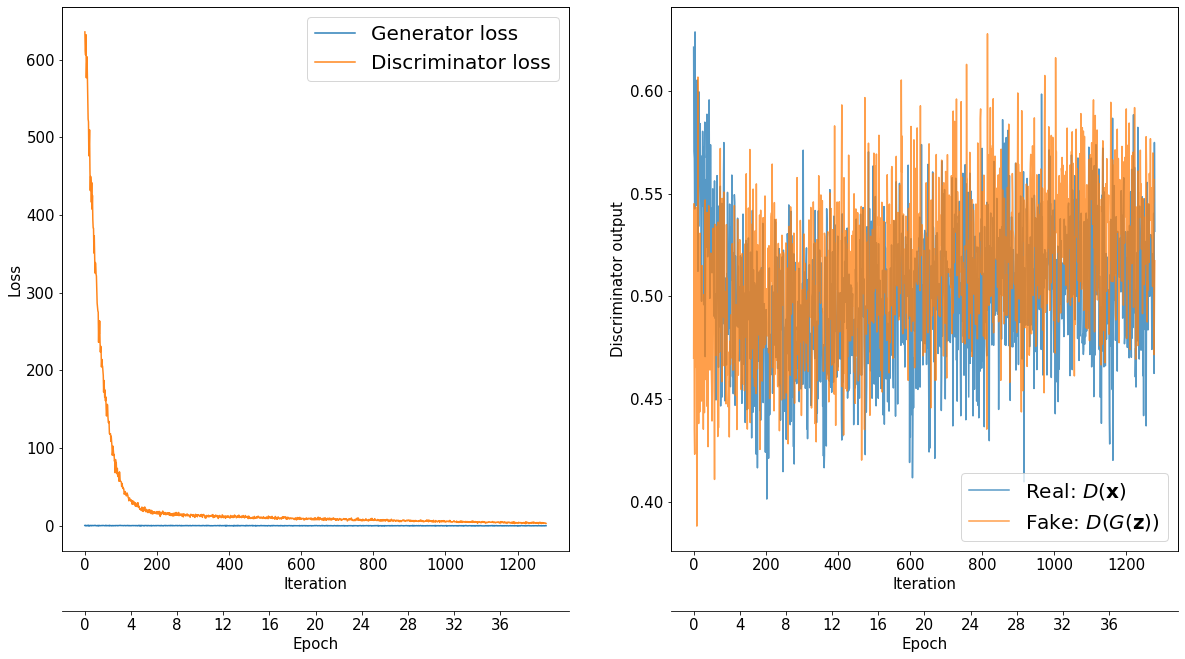

In [56]:
enh = enhance_data(
    x_train=x_train_processed, y_train=y_train, 
    force_generator=True, 
    synthetic_share=1., 
    wasserstein=True,
    replace_real_data=True
)

## set up the data log

In [57]:
log = pd.DataFrame(columns=["model", "accuracy", "enhanced_data"])
log['enhanced_data'] = log['enhanced_data'].astype(bool)

## logReg

In [58]:
clf = LogisticRegression(solver='liblinear')

clf.fit(x_train_processed, y_train)

y_pred = clf.predict(x_test_processed)

clf.score(x_train_processed, y_train)

score = accuracy_score(y_test, y_pred)

log = log.append({"model": "logistic regression", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [59]:
clf = LogisticRegression(solver='liblinear')

clf.fit(enh['x_train_processed'], enh['y_train'])

y_pred = clf.predict(x_test_processed)

score = accuracy_score(y_test, y_pred)


log = log.append({"model": "logistic regression", "accuracy": score, "enhanced_data": True}, ignore_index=True)


## SVC

In [60]:
model = SVC(kernel="rbf",C=1)

model.fit(x_train_processed, y_train)

y_pred = model.predict(x_test_processed)

score = accuracy_score(y_test, y_pred)

log = log.append({"model": "SVC", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [61]:
model = SVC(kernel="rbf",C=1)

model.fit(enh['x_train_processed'], enh['y_train'])

y_pred = model.predict(x_test_processed)

score = accuracy_score(y_test, y_pred)

log = log.append({"model": "SVC", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## Random Forest

In [62]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(x_train_processed, y_train)
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Random Forest", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [63]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(enh['x_train_processed'], enh['y_train'])
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Random Forest", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## Decision Tree

In [64]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=7)
clf.fit(x_train_processed, y_train)
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Decision tree", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [65]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=7)
clf.fit(enh['x_train_processed'], enh['y_train'])
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Decision tree", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## KNN

In [66]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(x_train_processed, y_train)
clf.predict(x_test_processed)
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "K nearest neighbours", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [67]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(enh['x_train_processed'], enh['y_train'])
clf.predict(x_test_processed)
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "K nearest neighbours", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## Naive Bayes

In [68]:
clf = GaussianNB()
clf.fit(x_train_processed, y_train)
clf.predict(x_test_processed)
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "GaussianNB", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [69]:
clf = GaussianNB()
clf.fit(enh['x_train_processed'], enh['y_train'])
clf.predict(x_test_processed)
y_pred = clf.predict(x_test_processed)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "GaussianNB", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## NeuralNet

In [70]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=x_train_processed.shape[1:]))

for i in range(5):
        model.add(layers.Dense(
            64, 
            kernel_initializer='he_normal',
            name=f'hidden_layer_{i}'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('selu'))
        model.add(layers.Dropout(0.3, name=f'dropout_{i}_30'))
    
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 64)                896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_0_30 (Dropout)       (None, 64)                0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_6 (Activation)    (None, 64)               

In [71]:
history = model.fit(
    x_train_processed, y_train, validation_split=.2, epochs=300,
    callbacks=[
        EarlyStopping(patience=20, monitor='val_accuracy', mode='max', restore_best_weights=True)])

Epoch 1/300
27/27 [==============================] - 3s 35ms/step - loss: 0.7465 - accuracy: 0.6559 - val_loss: 0.8255 - val_accuracy: 0.7476
Epoch 2/300
27/27 [==============================] - 1s 30ms/step - loss: 0.6150 - accuracy: 0.7384 - val_loss: 0.6548 - val_accuracy: 0.7429
Epoch 3/300
27/27 [==============================] - 1s 20ms/step - loss: 0.5968 - accuracy: 0.7133 - val_loss: 0.6265 - val_accuracy: 0.7333
Epoch 4/300
27/27 [==============================] - 0s 13ms/step - loss: 0.5504 - accuracy: 0.7515 - val_loss: 0.6293 - val_accuracy: 0.7476
Epoch 5/300
27/27 [==============================] - 0s 12ms/step - loss: 0.5739 - accuracy: 0.7312 - val_loss: 0.5844 - val_accuracy: 0.7429
Epoch 6/300
27/27 [==============================] - 1s 22ms/step - loss: 0.5544 - accuracy: 0.7634 - val_loss: 0.6168 - val_accuracy: 0.7429
Epoch 7/300
27/27 [==============================] - 0s 10ms/step - loss: 0.5264 - accuracy: 0.7670 - val_loss: 0.5975 - val_accuracy: 0.7429
Epoch 

In [72]:
result = model.evaluate(x_test_processed, y_test)
result[1]
log = log.append({"model": "DenseNeuralNet", "accuracy": result[1], "enhanced_data": False}, ignore_index=True)

9/9 [==============================] - 0s 4ms/step - loss: 0.5031 - accuracy: 0.7710


In [73]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=x_train_processed.shape[1:]))

for i in range(5):
        model.add(layers.Dense(
            64, 
            kernel_initializer='he_normal',
            name=f'hidden_layer_{i}'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('selu'))
        model.add(layers.Dropout(0.3, name=f'dropout_{i}_30'))
    
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    enh['x_train_processed'], enh['y_train'], validation_split=.2, epochs=300,
    callbacks=[
        EarlyStopping(patience=20, monitor='val_accuracy', mode='max', restore_best_weights=True)])

Epoch 1/300
27/27 [==============================] - 2s 35ms/step - loss: 0.5890 - accuracy: 0.7288 - val_loss: 0.6300 - val_accuracy: 0.8571
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 0.4492 - accuracy: 0.8208 - val_loss: 0.4230 - val_accuracy: 0.8810
Epoch 3/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4009 - accuracy: 0.8268 - val_loss: 0.3742 - val_accuracy: 0.8857
Epoch 4/300
27/27 [==============================] - 0s 11ms/step - loss: 0.3742 - accuracy: 0.8423 - val_loss: 0.2471 - val_accuracy: 0.8905
Epoch 5/300
27/27 [==============================] - 0s 15ms/step - loss: 0.3805 - accuracy: 0.8542 - val_loss: 0.2414 - val_accuracy: 0.8952
Epoch 6/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3201 - accuracy: 0.8638 - val_loss: 0.2274 - val_accuracy: 0.9095
Epoch 7/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3104 - accuracy: 0.8769 - val_loss: 0.2149 - val_accuracy: 0.9095
Epoch 8/30

In [74]:
result = model.evaluate(x_test_processed, y_test)
result[1]
log = log.append({"model": "DenseNeuralNet", "accuracy": result[1], "enhanced_data": True}, ignore_index=True)

9/9 [==============================] - 1s 16ms/step - loss: 1.9973 - accuracy: 0.5153


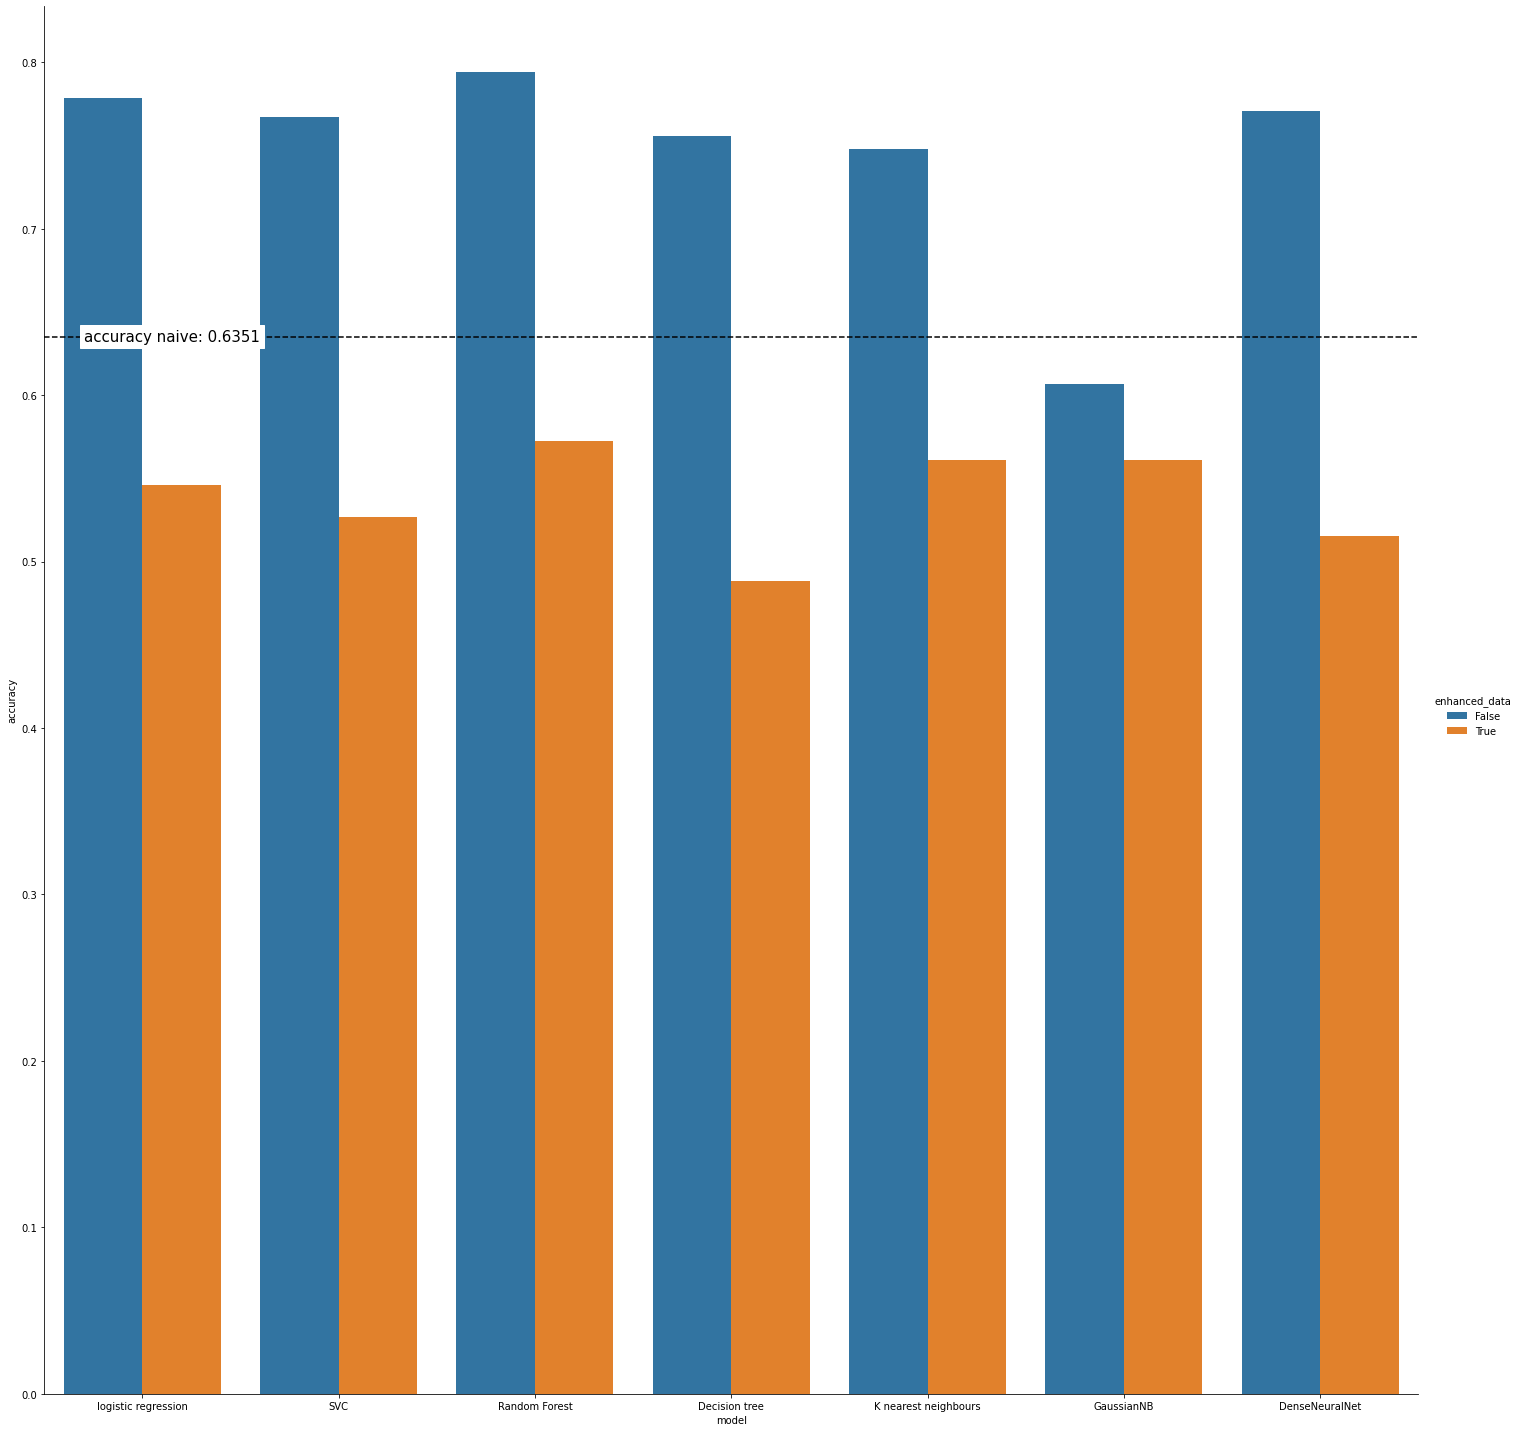

In [75]:
import seaborn as sns
from matplotlib import pyplot as plt


c = sns.catplot(
    data=log,
    x='model',
    y='accuracy',
    hue='enhanced_data',
    kind='bar',
    height=20
)

naive_baseline = 1 - y_train.mean()

axes = c.axes.flatten()
for i, ax in enumerate(axes):
    accuracy = naive_baseline
    
    ax.axhline(accuracy, ls='--', c='black')
    ax.text(0.15, accuracy, 
            f'accuracy naive: {round(accuracy, 4)}', 
            fontsize=15, va='center', ha='center', backgroundcolor='w')


plt.savefig('./titanic_all_models_replacing_experiments.jpg')